### Learning to rank with XGB - more data


- 1 Million rows

- loss considers NDCG

- Feature and row selection as in https://docs.google.com/document/d/1R9itgngZUNzkBqWzXstLiBXXoYJa8-ahS66JrqC3kDk/edit

- after feature selection: check for queries with one row/no click/transaction
- preprocessed: no queries with only one result, numerical variables scaled
- click and transaction in one relevance label (click weight: 1, transaction weight: 2)



code folllows this example: https://xgboost.readthedocs.io/en/stable/tutorials/learning_to_rank.html

In [2]:
import pandas as pd
df = pd.read_csv('/home/constructor/FinalProjects/Expedia_new/allRank_WS/expedia_data/processed/MillionRows/AllDest100Rank.csv')

#### Create relevance column from user interactions (clicks, bookings)

In [3]:
df["relevance"] = 0  # Initialize with default value
df.loc[df["num_clicks"] > 0, "relevance"] = 1  # Set value to 1 if first_column > 0
df.loc[df["is_trans"] > 0, "relevance"] = 2  # Add 2 if second_column > 0

#### Drop columns (features) not needed 

In [4]:
df = df.drop(columns = ["search_day_of_week", "search_hour_of_day",
                        "checkout_date", "infant_count", "room_count", "rank",
                        "user_id","is_trans", "num_clicks"])

df.shape

(9171332, 40)

#### Drop or filter rows based on conditions

In [5]:
# Keeping only recommended sort_type

df_model = df[df["sort_type"] == "RECOMMENDED"]

df_model.drop(columns='sort_type', inplace=True)

# remove star_rating = Not Available
df_model = df_model[df_model["star_rating"] != "Not Available"]

# remove if review rating == 0, because indicates that no rating could be given
df_model = df_model[df_model["review_rating"] != 0.0]

# transfer star rating to a numeric value
df_model["star_rating"] = pd.to_numeric(df_model["star_rating"])

# exclude ads
df_model = df_model[df_model['is_travel_ad'] == 0]

# Extract month from checkin_date

df_model["checkin_month"] = pd.to_datetime(df_model["checkin_date"]).dt.month

# transform month to category
df_model["checkin_month"] = df_model["checkin_month"].astype("category")
df_model['checkin_day'] = df_model['checkin_day'].astype('category')
df_model['checkout_day'] = df_model['checkout_day'].astype('category')

# drop string and date time of checkin
df_model = df_model.drop(columns = ["checkin_date"])

# replace True False strings with 1 and 0

df_model = df_model.replace({"True": 1, "False": 0})

/tmp/ipykernel_276502/2764890452.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.drop(columns='sort_type', inplace=True)


In [6]:
amenities =  ['AirConditioning',
  'AirportTransfer',
  'Bar',
  'FreeAirportTransportation',
  'FreeBreakfast',
  'FreeParking',
  'FreeWiFi',
  'Gym',
  'HighSpeedInternet',
  'HotTub',
  'LaundryFacility',
  'Parking',
  'PetsAllowed',
  'PrivatePool',
  'SpaServices',
  'SwimmingPool',
  'WasherDryer',
  'WiFi']



# change type to category:
for amenity in amenities:
  df_model[amenity] = df_model[amenity].astype('int')

In [7]:
df_amenities = pd.read_csv('/home/constructor/FinalProjects/Expedia_new/allRank_WS/expedia_data/processed/MillionRows/amenities.tsv.gz', compression='gzip', sep='\t')

In [8]:
df_model['number_of_amenities'] = df_model[df_amenities.columns.difference(['prop_id'])].sum(axis=1)

In [9]:
categorical_features = df_model.select_dtypes(include=['category','object']).columns.tolist()

categorical_features

['checkin_day', 'checkout_day', 'checkin_month']

In [23]:
# drop rows with NaN values
df_model = df_model.dropna()

df_model.shape

(7609371, 40)

In [24]:
#### check data before test - train split

# are there qids with only one row?
# throw out rows where qid is unique - for those ndcg is not possible to calculate
# Find counts of each group
group_counts = df_model["search_id"].value_counts()
unique_groups = group_counts[group_counts == 1].index

filtered_df = df_model[~df_model["search_id"].isin(unique_groups)]
filtered_df.shape

(7608825, 40)

#### Train test split


In [12]:
from sklearn.model_selection import GroupShuffleSplit

def split_by_qid(df, test_size):
    gss = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=42)
    ids = df['search_id'].unique()
    train_idx, test_idx = next(gss.split(ids, groups=ids))
    return df[df['search_id'].isin(ids[train_idx])], df[df['search_id'].isin(ids[test_idx])]

#_, temp_df = split_by_qid(df2, test_size=0.2)
train_df, test_df = split_by_qid(df_model, test_size=0.3)

train_df.shape, test_df.shape

((5335572, 40), (2273799, 40))

In [13]:
# data needs to be ordered by qid for XGBRank function
train_df = train_df.sort_values(by = "search_id")
X_train = train_df.drop(columns = ["search_id", "relevance"])

# relevance label is outcome var
y_train = train_df["relevance"]
qid_train = train_df["search_id"]

In [14]:
# same data format for test data
test_df = test_df.sort_values(by = "search_id")

X_test = test_df.drop(columns = ["search_id", "relevance"])

y_test = test_df["relevance"]
qid_test = test_df["search_id"]

In [15]:
categorical_features = X_train.select_dtypes(include=['category','object']).columns.tolist()
numeric_features = X_train.select_dtypes(exclude=['category','object']).columns.tolist()

# take out destination ID and geo_location_country and point_of_sale from list so it can be encoded separately
numeric_features.remove("destination_id")
numeric_features.remove("geo_location_country")
numeric_features.remove("point_of_sale")


categorical_features, numeric_features

(['checkin_day', 'checkout_day', 'checkin_month'],
 ['is_mobile',
  'adult_count',
  'child_count',
  'length_of_stay',
  'booking_window',
  'prop_id',
  'is_travel_ad',
  'review_rating',
  'review_count',
  'star_rating',
  'is_free_cancellation',
  'is_drr',
  'price_bucket',
  'AirConditioning',
  'AirportTransfer',
  'Bar',
  'FreeAirportTransportation',
  'FreeBreakfast',
  'FreeParking',
  'FreeWiFi',
  'Gym',
  'HighSpeedInternet',
  'HotTub',
  'LaundryFacility',
  'Parking',
  'PetsAllowed',
  'PrivatePool',
  'SpaServices',
  'SwimmingPool',
  'WasherDryer',
  'WiFi',
  'number_of_amenities'])

#### Feature pre-processing

In [16]:
!pip install -q category_encoders

In [17]:
import sklearn
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
### encode categorical with high cardinality
sklearn.set_config(transform_output="pandas")
from category_encoders.target_encoder import TargetEncoder



In [18]:
# Set the option to opt-in to the future behavior
pd.set_option('future.no_silent_downcasting', True)

### encode destination ID and geo_location_country and point_of_sale
enc = TargetEncoder(cols=["destination_id", "geo_location_country", "point_of_sale","prop_id"]).fit(X_train, y_train)

X_train = enc.transform(X_train)
X_test = enc.transform(X_test)

In [19]:
numeric_features = ['adult_count',
 'child_count',
 'length_of_stay',
 'booking_window',
 'review_count','number_of_amenities']

numeric_features, categorical_features

(['adult_count',
  'child_count',
  'length_of_stay',
  'booking_window',
  'review_count',
  'number_of_amenities'],
 ['checkin_day', 'checkout_day', 'checkin_month'])

In [20]:
# scale numerical
scaler=StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [21]:
# create dummies for categorical
X_train = pd.get_dummies(X_train, columns=categorical_features)
X_test = pd.get_dummies(X_test, columns=categorical_features)

In [22]:
from sklearn.datasets import dump_svmlight_file

# Save X_train as SVMLight file with .txt extension
file_path_train = '/home/constructor/FinalProjects/Expedia_new/allRank_WS/expedia_data/0501_61C_MoreRank/train.txt'
dump_svmlight_file(X_train, y_train, f=file_path_train, query_id=qid_train)

# Save X_test as SVMLight file with .txt extension
file_path_test = '/home/constructor/FinalProjects/Expedia_new/allRank_WS/expedia_data/0501_61C_MoreRank/test.txt'
dump_svmlight_file(X_test, y_test, f=file_path_test, query_id=qid_test)

In [28]:
!pip install -q xgboost

In [29]:
import xgboost as xgb

In [30]:
# use the examplary code from xgboost documentation as a starting point:
# https://xgboost.readthedocs.io/en/stable/python/examples/learning_to_rank.html#sphx-glr-python-examples-learning-to-rank-py
# specifically for click data

ranker = xgb.XGBRanker(
        n_estimators=100, #512
        tree_method="hist",
        device="cuda",
        learning_rate=0.01,
        reg_lambda=0.05,
        subsample=0.8,
        sampling_method="gradient_based",
        # to handle categorical features with many features
        #enable_categorical=True,
        # above 7 categories no one hot encoding
        #max_cat_to_onehot = 7,
        #max_cat_threshold = 15,
        # LTR specific parameters
        objective="rank:ndcg",
        # - Enable bias estimation
        lambdarank_unbiased=True,
        # - normalization (1 / (norm + 1))
        lambdarank_bias_norm=1,
        # - Focus on the top 12 documents
        lambdarank_num_pair_per_sample=12,
        lambdarank_pair_method="topk",
        ndcg_exp_gain=True,
        eval_metric=["ndcg@1", "ndcg@3", "ndcg@5", "ndcg@10", "ndcg@50"],
        lambdarank_normalization = False
 )

In [32]:
corr = X_train[["point_of_sale", "geo_location_country", "is_mobile",
                "destination_id", "adult_count", "child_count", "length_of_stay",
                "booking_window", "review_rating", "review_count", "star_rating",
                "is_free_cancellation", "is_drr", "price_bucket",
                ]].corr(numeric_only=True)

<Axes: >

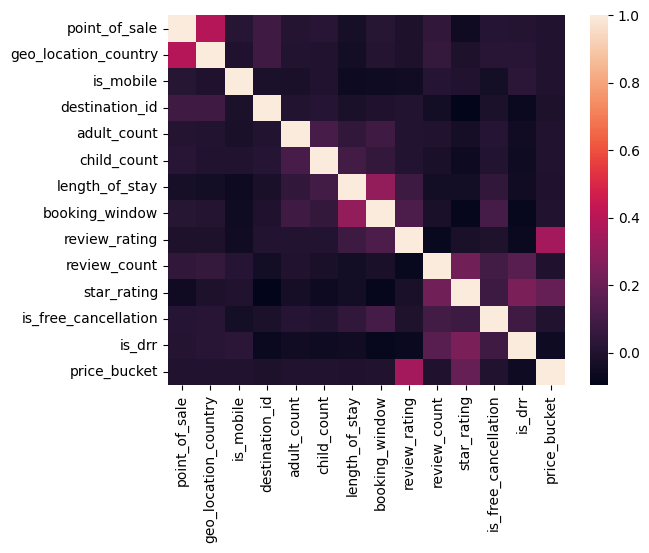

In [33]:
import seaborn as sns
sns.heatmap(corr)

In [34]:
# fit on training data

ranker.fit(
    X_train,
    y_train,
    qid=qid_train,
    eval_set=[(X_test, y_test)],
    eval_qid=[qid_test],
    verbose = True,
    early_stopping_rounds = 15
)

/home/constructor/.conda/envs/expedia_310/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/constructor/.conda/envs/expedia_310/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:59:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "lambdarank_normalization" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-ndcg@1:0.18389	validation_0-ndcg@3:0.25726	validation_0-ndcg@5:0.29882	validation_0-ndcg@10:0.35528	validation_0-ndcg@50:0.44575
[1]	validation_0-ndcg@1:0.18742	validation_0-ndcg@3:0.25901	validation_0-ndcg@5:0.30000	validation_0-ndcg@10:0.35608	validation_0-ndcg@50:0.44717
[2]	validation_0-ndcg@1:0.18666	validation_0-ndcg@3:0.25946	validation_0-ndcg@5:0.30146	validation_0-ndcg@10:0.35696	validation_0-ndcg@50:0.44778
[3]	validation_0-ndcg@1:0.18734	validation_0-ndcg@3:0.26029	validation_0-ndcg@5:0.30183	validation_0-ndcg@10:0.35763	validation_0-ndcg@50:0.44809
[4]	validation_0-ndcg@1:0.18742	validation_0-ndcg@3:0.26011	validation_0-ndcg@5:0.30180	validation_0-ndcg@10:0.35795	validation_0-ndcg@50:0.44831
[5]	validation_0-ndcg@1:0.18806	validation_0-ndcg@3:0.26028	validation_0-ndcg@5:0.30217	validation_0-ndcg@10:0.35825	validation_0-ndcg@50:0.44840
[6]	validation_0-ndcg@1:0.18797	validation_0-ndcg@3:0.26036	validation_0-ndcg@5:0.30233	validation_0-ndcg@10:0.35828	validat

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device='cuda',
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=['ndcg@1', 'ndcg@3', 'ndcg@5', 'ndcg@10', 'ndcg@50'],
          feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None,
          lambdarank_bias_norm=1, lambdarank_normalization=False,
          lambdarank_num_pair_per_sample=12, lambdarank_pair_method='topk',
          lambdarank_unbiased=True, learning_rate=0.01, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=None, max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, ...)

Prediction: needs to be done by query in query_test

---

To do:
- calculate a scores by query, then calculate ndcg for each query
- how needs data to be stored/ordered/porvided?
- what is the scoring function used as default
- should it be replaced by NDCG?

In [ ]:
import numpy as np

def ndcg(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

In [ ]:
# this yields the same result as ndcg@10 when I provide the eval set in the ranker.fit
# https://forecastegy.com/posts/xgboost-learning-to-rank-python/

# here I did not provide eval_set and calculated the NDCG "by hand" with ranker.predict
qids = np.unique(qid_test)


ndcg_ = list()

for i, qid in enumerate(qids):
    y = y_test[qid_test == qid]

    if np.sum(y) == 0:
        continue

    p = ranker.predict(X_test[qid_test == qid])

    idcg = ndcg(y, y, k=10)
    ndcg_.append(ndcg(p, y, k=10) / idcg)

np.mean(ndcg_)
# 0.618

# calculates scores over all queries
# scores = ranker.predict(X_test, qid = qid_test)

# y_test_df = pd.DataFrame({"relevance": y_test, "predicted_scores": scores, "qid": qid_test})

0.6210364520430335

In [ ]:
qids = np.unique(qid_test)


scores = list()

for i, qid in enumerate(qids):
    y = y_test[qid_test == qid]

    if np.sum(y) == 0:
        continue

    scores.append(ranker.predict(X_test[qid_test == qid]))

In [ ]:
from sklearn.metrics import ndcg_score

# throw out rows where qid is unique - for those ndcg is not possible to calculate
# Find counts of each group
group_counts = y_test_df['qid'].value_counts()
unique_groups = group_counts[group_counts == 1].index
filtered_df = y_test_df[~y_test_df['qid'].isin(unique_groups)]


(116639, 3)

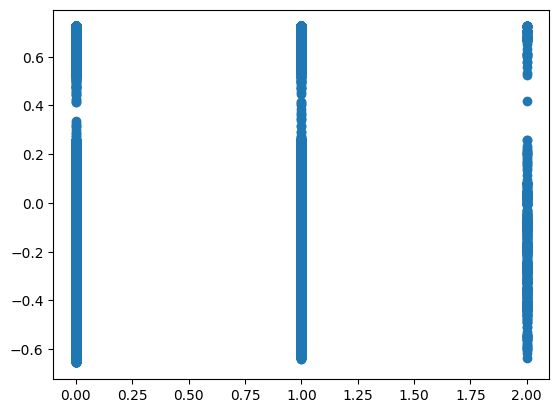

In [ ]:
### scatter plot of relevance and score
# we expect a higher predicted ranking vor values 1 and 2 on x - axis
plt.scatter(y_test_df["relevance"], y_test_df["predicted_scores"])

y_test_df.shape # can this plot be made for a specific search

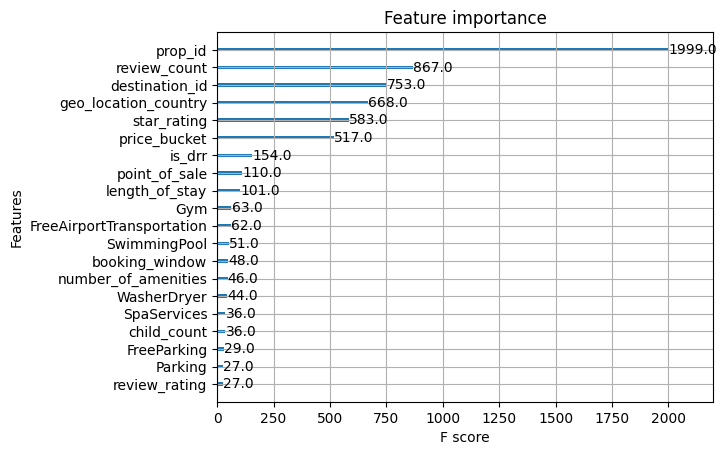

In [37]:
#### show feature importance
import matplotlib.pyplot as plt
from xgboost import plot_importance
# from matplotlib import pyplot

plot_importance(ranker, max_num_features=20)
plt.show()


